In [1]:
from helpers.other_helpers import *
from helpers.viz_helpers import *
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
s3 = s3_connection()
df = s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
df.sample(3)

connection successful


,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km,regions
1526,43191,Nuits sous Ravières,87713156,89280,4.21,47.73,89280,NUITS,367.00,14780.12,...,0.00,0.00,0.05,0.00,0.03,0.11,0.81,0.11,15.43,Bourgogne-Franche-Comté
2219,64839,Vireux-Molhain,87172114,08486,4.72,50.08,08486,VIREUX-MOLHAIN,1420.00,13923.91,...,0.19,0.02,0.07,0.10,0.10,0.36,0.35,0.13,3.64,Grand Est
1460,729,Luc,87734368,48086,3.89,44.65,48086,LUC,285.00,10207.41,...,0.08,0.29,0.00,0.00,0.71,0.00,0.00,0.00,6.81,Occitanie


In [3]:
df.describe().drop("count").drop(columns=["lon_gare", "lat_gare"]).round(2)

,total_voyageurs_2022,pop2022,revmoy2022,pbac2022,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km
mean,745465.89,18078.54,18221.52,0.46,0.29,0.01,0.07,0.14,0.26,0.29,0.23,0.07,4.86
std,3178484.88,50290.90,6608.60,0.13,0.13,0.04,0.06,0.11,0.11,0.11,0.12,0.05,3.73
min,1.00,55.00,5818.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
25%,12938.50,1570.25,14922.08,0.37,0.20,0.00,0.04,0.07,0.21,0.23,0.14,0.04,2.22
50%,60333.50,4067.50,16931.46,0.45,0.28,0.00,0.06,0.12,0.26,0.29,0.22,0.07,3.82
75%,289815.25,12203.00,19639.30,0.54,0.37,0.01,0.09,0.19,0.31,0.35,0.30,0.10,6.27
max,102910589.00,875791.00,107572.81,1.00,1.00,0.58,0.67,0.82,0.92,1.00,1.00,0.48,30.39


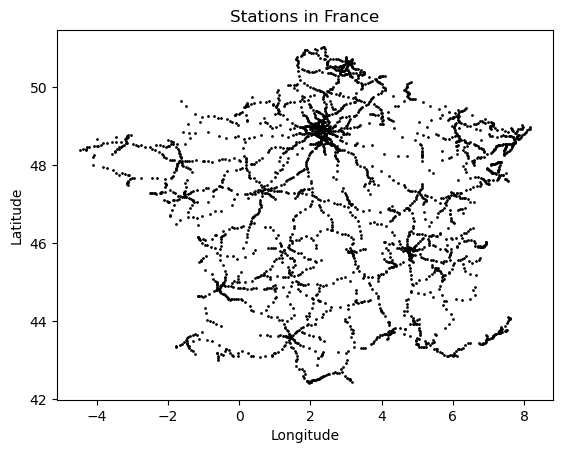

In [4]:
simple_plot_map(lat=df["lat_gare"], lon=df["lon_gare"])
idf=df[df["regions"]=="Île-de-France"]


In [5]:
df["total_voyageurs_2022_log"] =  np.log(df["total_voyageurs_2022"])
df["pop2022_log"] =  np.log(df["pop2022"])
df["pagri2022_log"] =  np.log(df["pagri2022"]+0.0001)
df["ratio_voyag_popul"] =  df["total_voyageurs_2022"] / df["pop2022"]
df["ratio_voyag_popul_log"] =  np.log(df["total_voyageurs_2022"] / df["pop2022"])
df_no_outliers = delete_outliers_z_score(df, np.log(df["total_voyageurs_2022"]))



nb removed observations :  18


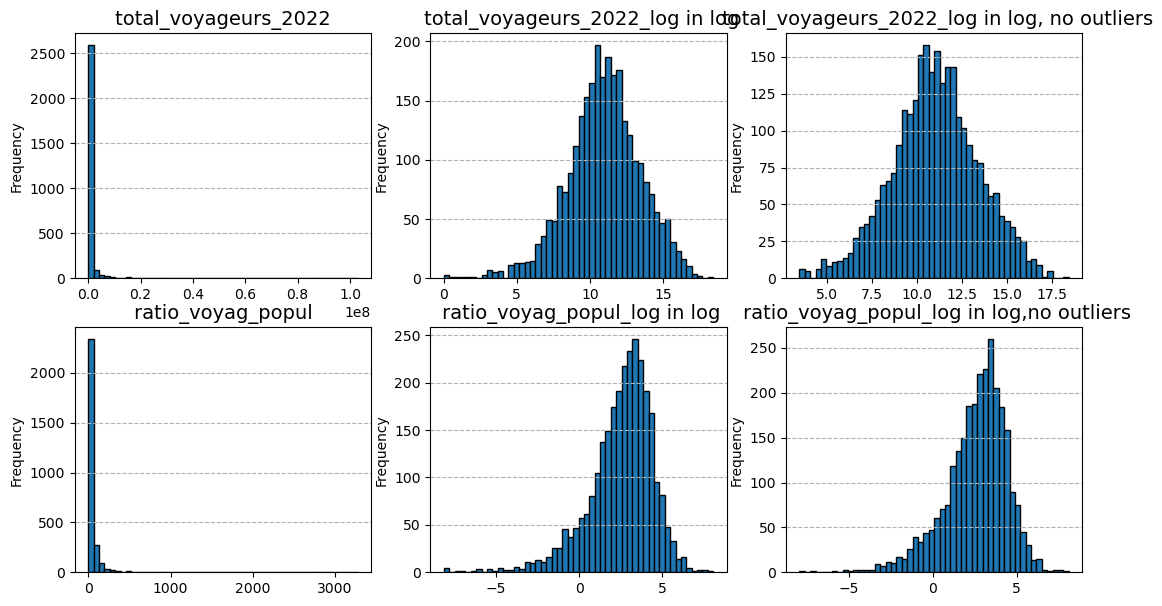

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(13, 7))  # 3 rows, 1 column of plots

plot_hist(axs[0,0], df["total_voyageurs_2022"], title_suffix="")
plot_hist(axs[0,1], (df["total_voyageurs_2022_log"]), title_suffix="in log")
plot_hist(
    axs[0,2],
    (df_no_outliers["total_voyageurs_2022_log"]),
    title_suffix="in log, no outliers",
)
plot_hist(
    axs[1,0],
    (df["ratio_voyag_popul"]),
   
)

plot_hist(
    axs[1,1],
    (df["ratio_voyag_popul_log"]),
    title_suffix="in log",
)

plot_hist(
    axs[1,2],
    (df_no_outliers["ratio_voyag_popul_log"]),
    title_suffix="in log,no outliers",
)



In [10]:
df=df_no_outliers.copy()
aggregated_stats = calculate(
    df,
    group=["regions"],
    fields_stats_names=[
        ["total_voyageurs_2022", "sum"],
        ["pop2022", "sum"],
        ["revmoy2022", "mean"],
        ["pbac2022", "mean"],
        ["pagri2022", "mean"],
        ["pindp2022", "mean"],
        ["pcadr2022", "mean"],
        ["pempl2022", "mean"],
        ["pouvr2022", "mean"],
        ["pchom2022", "mean"],
        
    ],
)
df_for_map = df.merge(aggregated_stats, on="regions", how="inner")

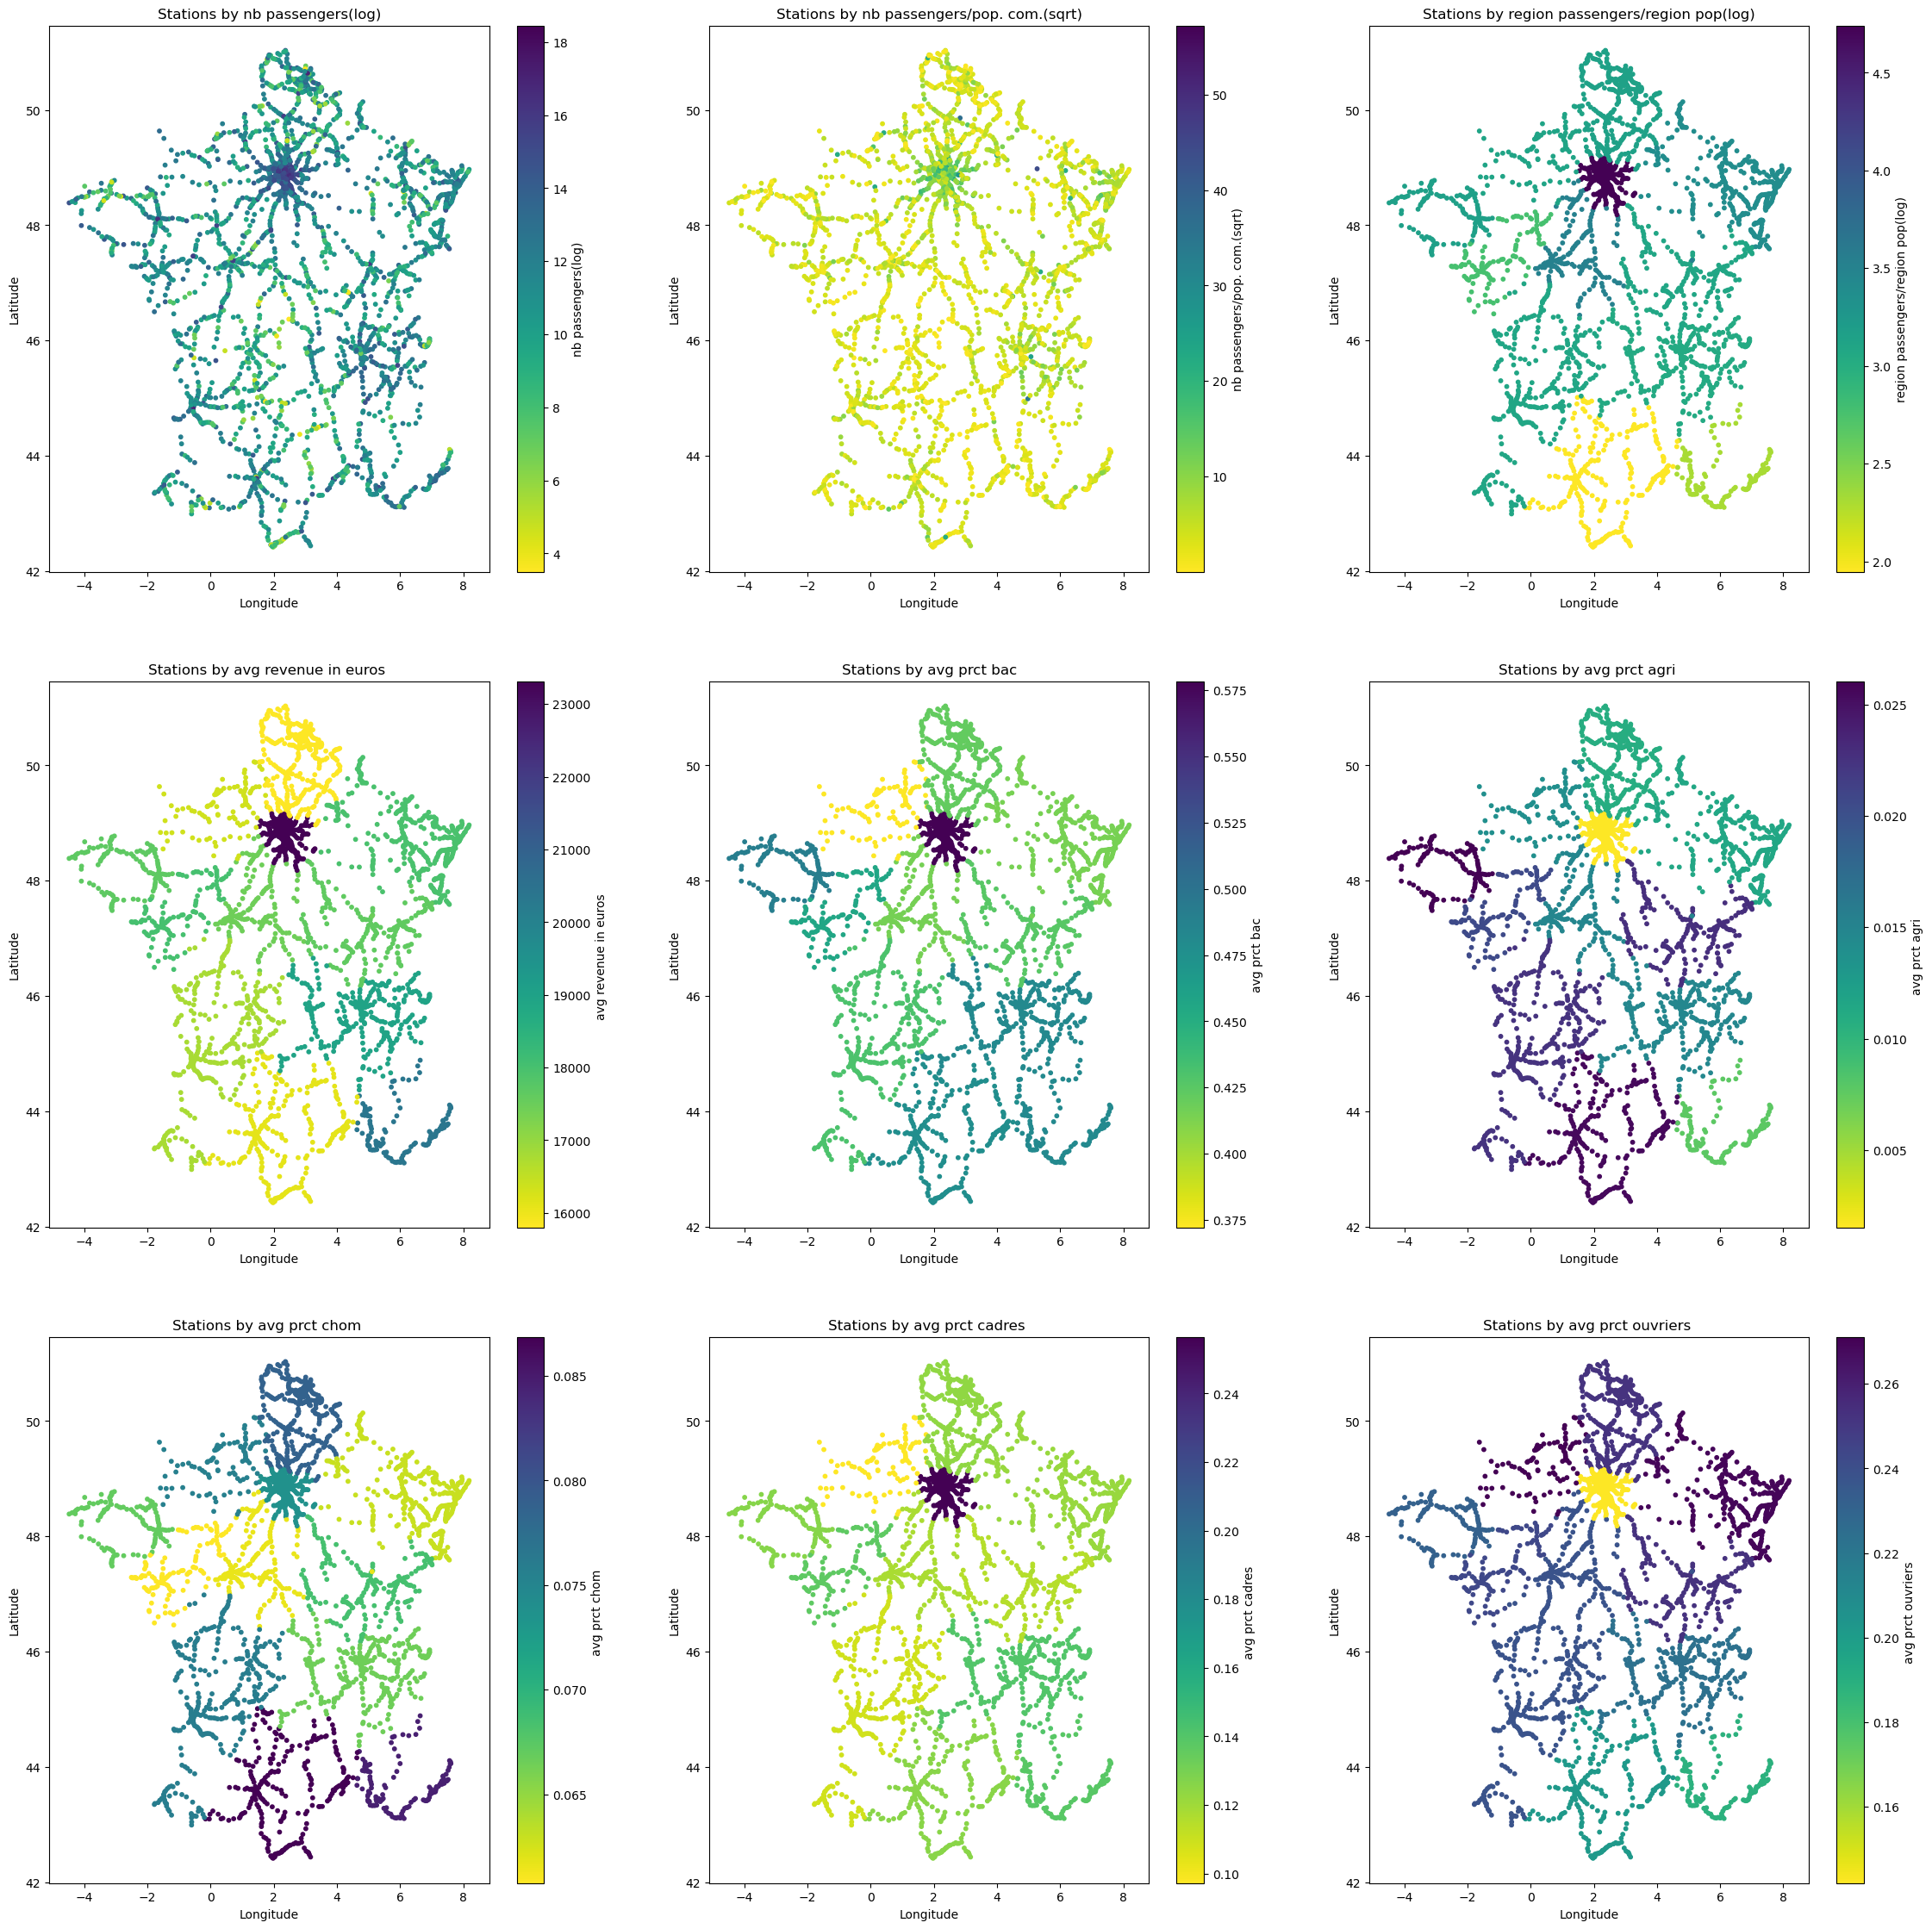

In [11]:
plot_square_map(lon=df_for_map["lon_gare"],lat=df_for_map["lat_gare"],
    fields_names=[
        [df_for_map["total_voyageurs_2022_log"], "nb passengers(log)"],
        [
            np.sqrt(
                df_for_map["ratio_voyag_popul"] 
            ),
            "nb passengers/pop. com.(sqrt)",
        ],
        [
            np.log(
                df_for_map["total_voyageurs_2022_sum"]
                / df_for_map["pop2022_sum"]
            ),
            "region passengers/region pop(log)",
        ],
        [
            (df_for_map["revmoy2022_mean"]),
            "avg revenue in euros ",
        ],
        [
            df_for_map["pbac2022_mean"],
            "avg prct bac",
        ],
        [
            df_for_map["pagri2022_mean"],
            "avg prct agri ",
        ],
        [
            (df_for_map["pchom2022_mean"]),
            "avg prct chom ",
        ],
        [
            df_for_map["pcadr2022_mean"],
            "avg prct cadres ",
        ],
        [
            df_for_map["pouvr2022_mean"],
            "avg prct ouvriers ",
        ],
        
       
    ]
)

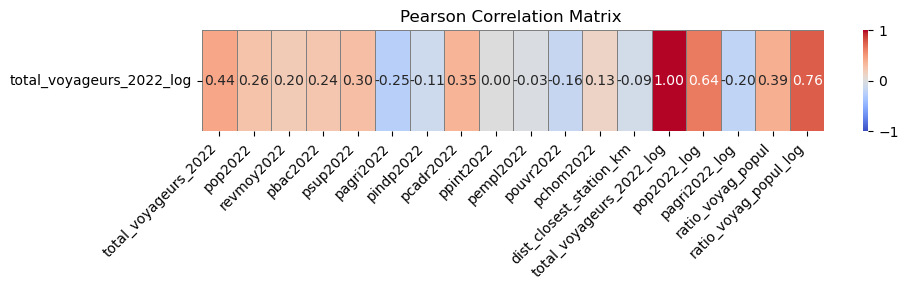

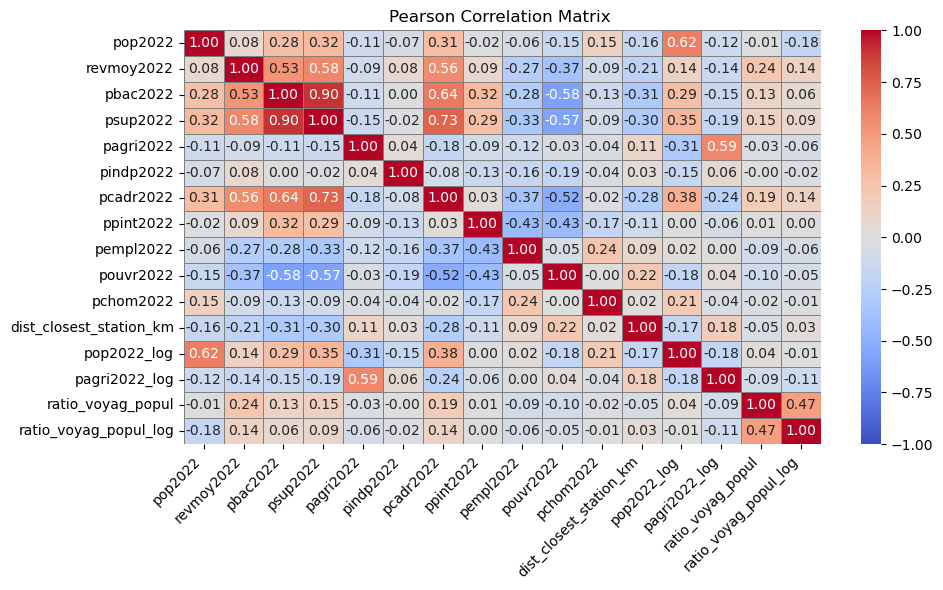

In [12]:
corr_matrix(df,filter_include=["total_voyageurs_2022_log"],filter_exclude=["lon_gare","lat_gare"],figsize=(10,3))
corr_matrix(df,filter_exclude=["total_voyageurs_2022_log","total_voyageurs_2022","lon_gare","lat_gare"])



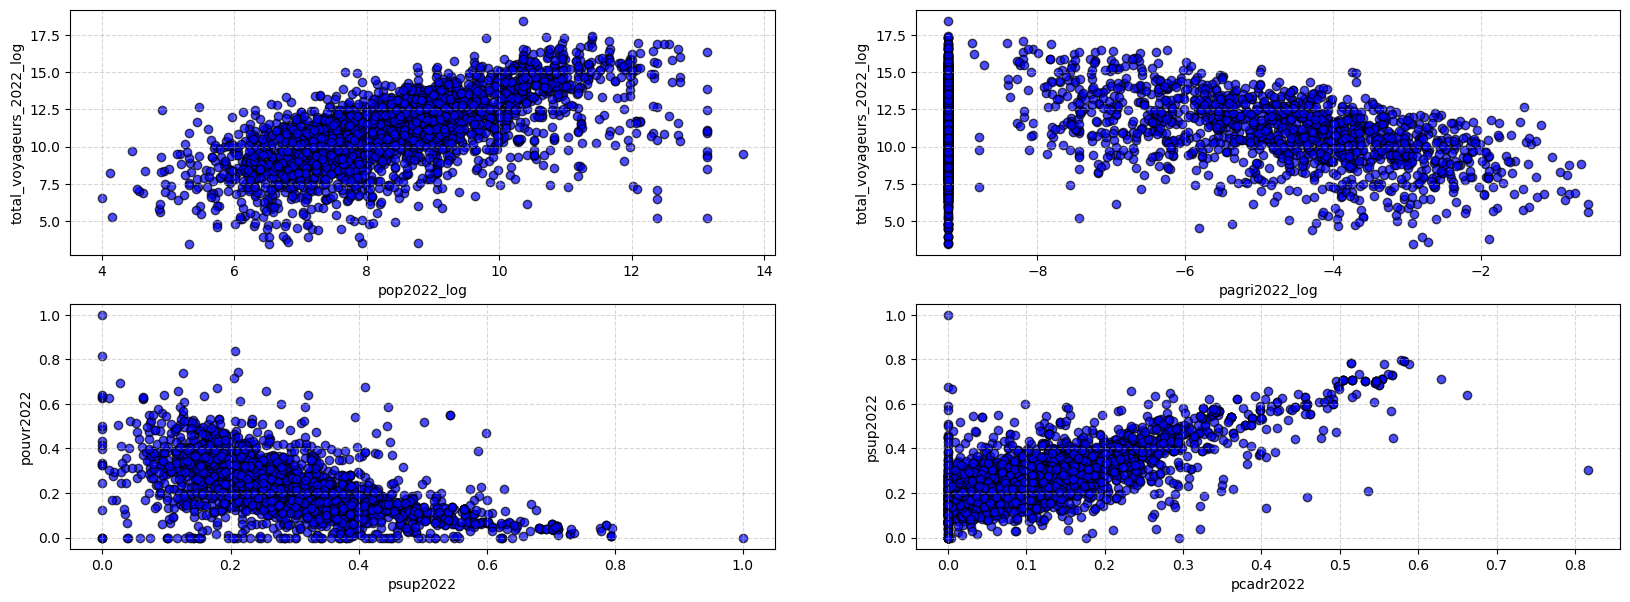

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))  # Adjust figsize as needed

plot_scatter(
    ax=axs[0,0],
    x_series=(df['pop2022_log']),
    y_series=df['total_voyageurs_2022_log'],
    
    
)

plot_scatter(
    ax=axs[0,1],
    x_series=(df['pagri2022_log']),
    y_series=df['total_voyageurs_2022_log'],
    

)
plot_scatter(
    ax=axs[1,0],
    x_series=(df['psup2022']),
    y_series=df['pouvr2022'],  

)
plot_scatter(
    ax=axs[1,1],
    x_series=(df['pcadr2022']),
    y_series=df['psup2022'],  

)




now lets look at the correlation between continuos variable and categorical regional variable to see if statistically on the individual level it is nterestuing to include it to analysis

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway



# Example: Categorical variable = 'regions', Continuous variable = 'total_voyageurs_2022'
def analysis_between_continous_and_categorical_var(df,category_var,interest_var,figsize=(12, 6)):
   #---------------VIZ PART--------------------------
   #-------------------------------
   plt.figure(figsize=figsize)  # Adjust figure size
   sns.boxplot(
       data=df,
       x=category_var  ,               # Your DataFrame
       hue=category_var, 
                     # Categorical variable
       y=interest_var,  # Continuous variable
       palette='Set2'   ,
       legend=False          # Optional: Color palette
   )
   
   # Rotate x-axis labels for better visibility
   plt.xticks(rotation=45)
   plt.title("Box Plot of Total Voyagers by Region")
   plt.xlabel("Regions")
   plt.ylabel("Total Voyagers (2022)")
   
   plt.tight_layout()
   plt.show()

   #---------------ANOVA TEST--------------------------
   #-------------------------------

   #cette partie suppose les données normales

   #filtrer par catégorie et extraire pour chaque catégorie le nb de voyageurs
   groups = [table[interest_var].values for region_filter, table in df.groupby(category_var)]
   #faire anova avec *, car c'est un requis de la fonction (args) 
   f_stat, p_value = f_oneway(*groups)
   print(f"P-value: {p_value:.4f}")
      
   if p_value < 0.05:
       print("Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.")
   else:
       print("Ne pas rejeter l'hypothèse nulle : Les moyennes des groupes ne sont pas significativement différente")
   print("-----------------------------------------")
   
   #---------------TUCKEY POST HOC TEST--------------------------
   #-------------------------------


   tukey = pairwise_tukeyhsd(endog=df[interest_var], groups=df[category_var], alpha=0.05)
   #supprimer les colonnes redondantes et avoir une belle table data frame
   tukey_summary = pd.DataFrame(
       data=tukey._results_table.data[1:],
       columns=tukey._results_table.data[0]  
   ) 
   nb_couples=tukey_summary[tukey_summary['reject'] == True].shape[0]
   print(nb_couples," combinaisons des catégories sont significativement différentes")

   

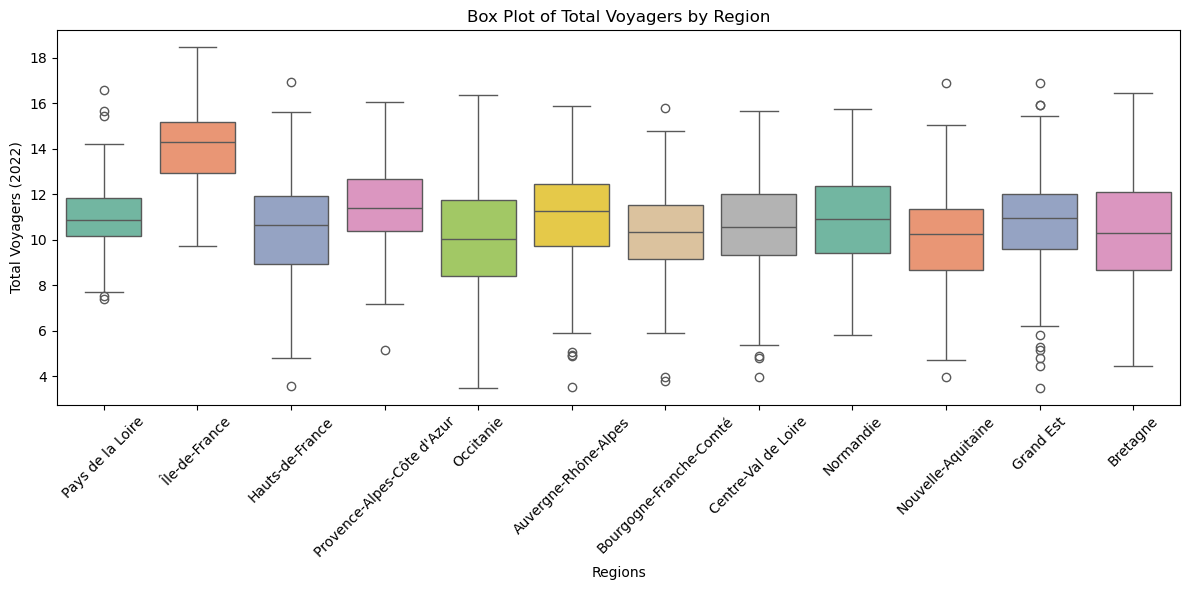

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
29  combinaisons des catégories sont significativement différentes


In [28]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='total_voyageurs_2022_log')

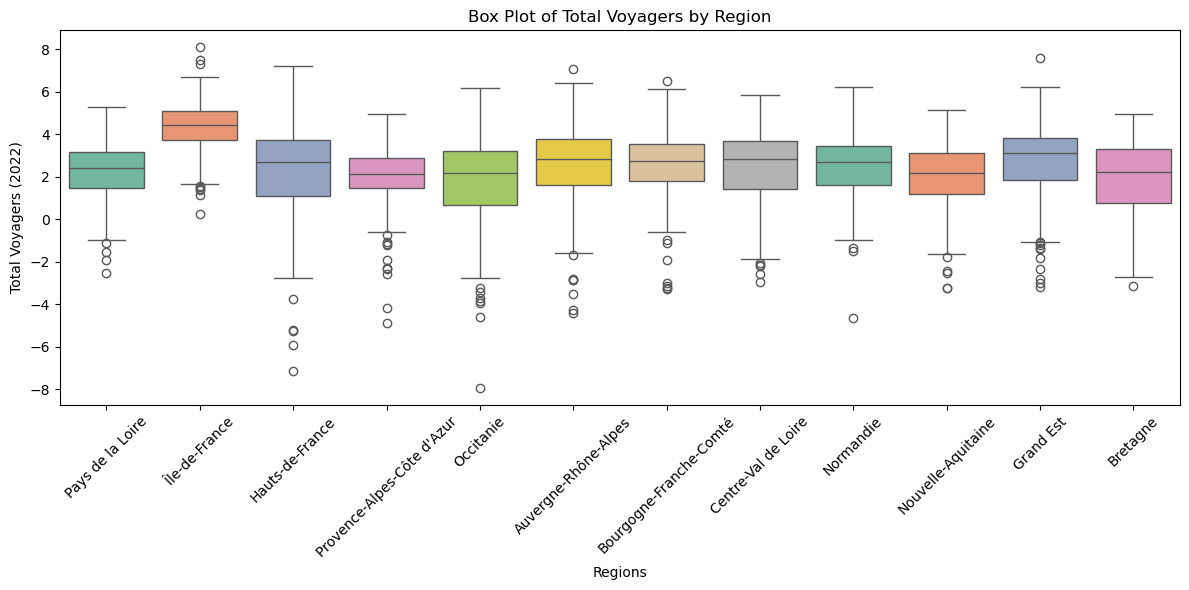

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
26  combinaisons des catégories sont significativement différentes


In [29]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='ratio_voyag_popul_log')
